In [1]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'
cofile = '../out/sorted_conditions.txt'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib_venn import venn2, venn3

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import random
import itertools
import numpy as np
import pandas as pd

In [4]:
co = [x.rstrip()
      for x in open(cofile)]

In [5]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [6]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']
pgenes = m.loc[(slice(None), genes),].groupby('gene')['phenotype'].max()
pgenes = set(pgenes[pgenes == True].index)

Y55 4190
S288C 4889
YPS 4093
UWOP 4014

total 3786


In [7]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [8]:
m = pd.read_table(dev)

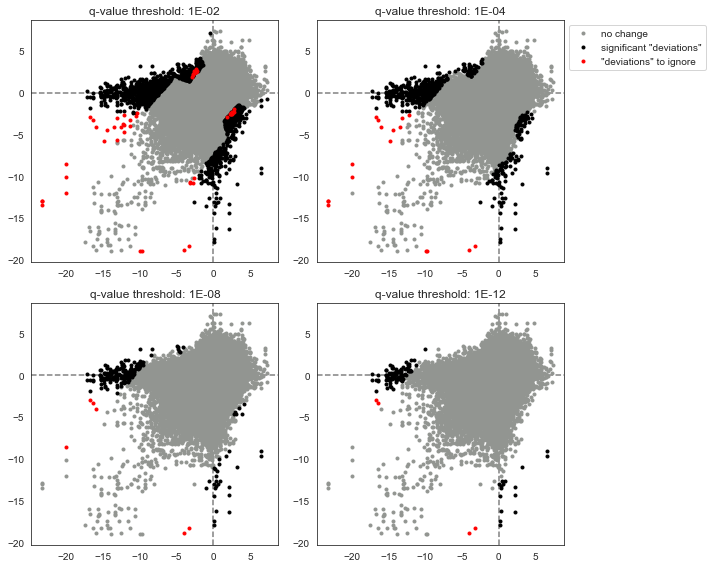

In [9]:
plt.figure(figsize=(10, 8))

for idx, pval in enumerate([1E-2, 1E-4, 1E-8, 1E-12]):
    plt.subplot(2, 2, idx+1)

    plt.axhline(0,
                color='grey',
                ls='dashed')
    plt.axvline(0,
                color='grey',
                ls='dashed')

    d = m[m['qval'] < pval].index

    plt.plot(m.loc[m.index.difference(d)]['scores1'],
             m.loc[m.index.difference(d)]['scores2'],
             '.',
             color=sns.xkcd_rgb['grey'],
             label='no change')

    e = m[(m['qval'] < pval) &
          ((m['phenotype1']) | (m['phenotype2']))].index
    f = m[(m['qval'] < pval) &
          ((m['phenotype1']) & (m['phenotype2'])) &
          (np.sign(m['scores1']) != np.sign(m['scores2']))].index
    g = m[(m['qval'] < pval) &
          ((m['phenotype1']) & (m['phenotype2'])) &
          (np.sign(m['scores1']) == np.sign(m['scores2']))].index

    d = d.difference(e).difference(f).difference(g)
    e = e.difference(f).difference(g)

    i = e.union(f)

    plt.plot(m.loc[i]['scores1'],
             m.loc[i]['scores2'],
             'k.',
             label='significant "deviations"')

    h = g.union(d)

    plt.plot(m.loc[h]['scores1'],
             m.loc[h]['scores2'],
             'r.',
             label='"deviations" to ignore')
    
    plt.title('q-value threshold: %0.E' % pval)

    if idx == 1:
        plt.legend(bbox_to_anchor=(1, 1),
                   loc='upper left',
                   frameon=True)

plt.tight_layout();

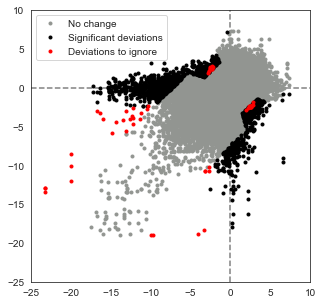

In [10]:
plt.figure(figsize=(5, 5))

pval = 1E-2
plt.axhline(0,
            color='grey',
            ls='dashed')
plt.axvline(0,
            color='grey',
            ls='dashed')

d = m[m['qval'] < pval].index

tmp = plt.plot(m.loc[m.index.difference(d)]['scores1'],
               m.loc[m.index.difference(d)]['scores2'],
               '.',
               color=sns.xkcd_rgb['grey'],
               label='No change')
for t in tmp:
    t.set_rasterized(True)

e = m[(m['qval'] < pval) &
      ((m['phenotype1']) | (m['phenotype2']))].index
f = m[(m['qval'] < pval) &
      ((m['phenotype1']) & (m['phenotype2'])) &
      (np.sign(m['scores1']) != np.sign(m['scores2']))].index
g = m[(m['qval'] < pval) &
      ((m['phenotype1']) & (m['phenotype2'])) &
      (np.sign(m['scores1']) == np.sign(m['scores2']))].index

d = d.difference(e).difference(f).difference(g)
e = e.difference(f).difference(g)

i = e.union(f)

tmp = plt.plot(m.loc[i]['scores1'],
               m.loc[i]['scores2'],
               'k.',
               label='Significant deviations')
for t in tmp:
    t.set_rasterized(True)

h = g.union(d)

tmp = plt.plot(m.loc[h]['scores1'],
               m.loc[h]['scores2'],
               'r.',
               label='Deviations to ignore')
for t in tmp:
    t.set_rasterized(True)

# plt.legend(bbox_to_anchor=(1, 1),
#            loc='upper left',
#            frameon=True)
plt.legend(loc='best')

plt.xlim(-25, 10)
plt.ylim(-25, 10)

plt.savefig('deviations-all.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations-all.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [11]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]
d = d.sort_index()

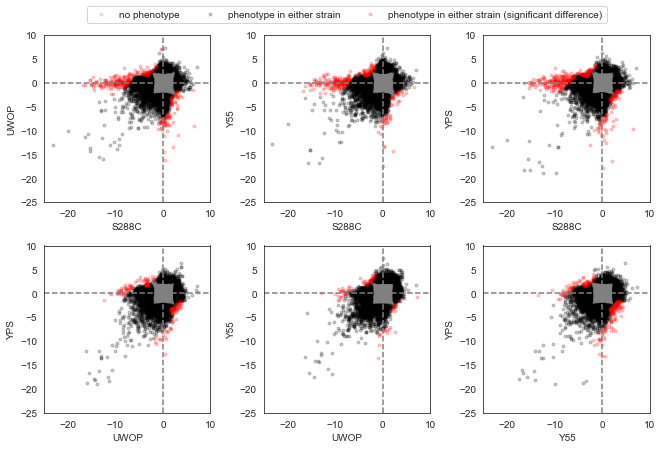

In [12]:
plt.figure(figsize=(9.3, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[0])

i = 1
for s1, s2 in ss:
    if i == 2:
        ax = plt.subplot(2, 3, i)
    else:
        plt.subplot(2, 3, i)
    
    label = 'no phenotype'
    label1 = 'phenotype in either strain'
    label2 = 'phenotype in either strain (significant difference)'
    
    x = d.loc[(s1, s2),]
    tmp = plt.plot(x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores1'],
                   x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores2'],
                   '.',
                   color='grey',
                   alpha=0.2,
                   label=label)
    for t in tmp:
        t.set_rasterized(True)
    tmp = plt.plot(x[(x['qvalue'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
                   x[(x['qvalue'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
                   'k.',
                   alpha=0.2,
                   label=label1)
    for t in tmp:
        t.set_rasterized(True)
    tmp = plt.plot(x[(x['qvalue'] < 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
                   x[(x['qvalue'] < 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
                   'r.',
                   alpha=0.2,
                   label=label2)
    for t in tmp:
        t.set_rasterized(True)
    
    plt.xlim(-25, 10)
    plt.ylim(-25, 10)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    i += 1

plt.tight_layout()
lg = ax.legend(loc='upper center',
               bbox_to_anchor=(0.5, 1.2),
               frameon=True,
               ncol=3)
for x in lg.legendHandles:
    lg.set_alpha(1)

plt.savefig('deviations.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

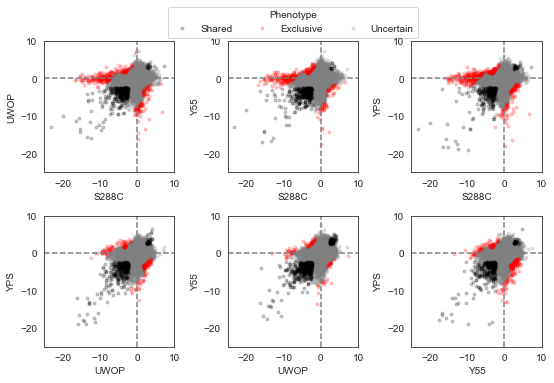

In [13]:
plt.figure(figsize=(7.8, 5))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[0])

i = 1
for s1, s2 in ss:
    if i == 2:
        ax = plt.subplot(2, 3, i)
    else:
        plt.subplot(2, 3, i)
    
    label = '_'
    label1 = 'Shared'
    label2 = 'Exclusive'
    label3 = 'Uncertain'
    
    x = d.loc[(s1, s2),]
    tmp = plt.plot(x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores1'],
                   x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores2'],
                   '.',
                   color='grey',
                   alpha=0.2,
                   label=label)
    for t in tmp:
        t.set_rasterized(True)
    tmp = plt.plot(x[(x['qvalue'] >= 1E-2) & (x['phenotype1'] & x['phenotype2'])]['scores1'],
                   x[(x['qvalue'] >= 1E-2) & (x['phenotype1'] & x['phenotype2'])]['scores2'],
                   'k.',
                   alpha=0.2,
                   label=label1)
    for t in tmp:
        t.set_rasterized(True)
    tmp = plt.plot(x[(x['qvalue'] < 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
                   x[(x['qvalue'] < 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
                   'r.',
                   alpha=0.2,
                   label=label2)
    for t in tmp:
        t.set_rasterized(True)
    tmp = plt.plot(x[(x['qvalue'] >= 1E-2) &
                     ((x['phenotype1'] & np.invert(x['phenotype2'])) |
                      (x['phenotype2'] & np.invert(x['phenotype1'])))]['scores1'],
                   x[(x['qvalue'] >= 1E-2) &
                     ((x['phenotype1'] & np.invert(x['phenotype2'])) |
                      (x['phenotype2'] & np.invert(x['phenotype1'])))]['scores2'],
                   '.',
                   color='grey',
                   alpha=0.2,
                   label=label3,
                   zorder=0)
    for t in tmp:
        t.set_rasterized(True)
    
    plt.xlim(-25, 10)
    plt.ylim(-25, 10)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    plt.xticks([-20, -10, 0, 10])
    plt.yticks([-20, -10, 0, 10])
    
    i += 1

plt.tight_layout()
lg = ax.legend(loc='upper center',
               bbox_to_anchor=(0.5, 1.3),
               frameon=True,
               ncol=3,
               title='Phenotype')
for x in lg.legendHandles:
    lg.set_alpha(1)

plt.savefig('deviations_edit.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_edit.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [14]:
res = []
for s1, s2 in sorted({tuple(x[:2])
                      for x in d.index},
                     key=lambda x: x[0]):
    v = d[d['phenotype1'] | d['phenotype2']].loc[(s1, s2),]
    idx = set(v.index)
    idx1 = set(v[v['phenotype1'] & np.invert(v['phenotype2']) & (v['qvalue'] < 1E-2)].index)
    idx2 = set(v[v['phenotype2'] & np.invert(v['phenotype1']) & (v['qvalue'] < 1E-2)].index)
    # switches
    idx3 = set(v[v['phenotype1'] & v['phenotype2'] & (v['qvalue'] < 1E-2)].index)
    idx = idx - idx1 - idx2 - idx3
    idx1 = idx1 - idx3
    idx2 = idx2 - idx3
    res.append(([len(idx1), len(idx), len(idx2), len(idx3)], [s1, s2]))

In [15]:
strains = {y
           for x in d.index
           for y in x[:2]}
palette = sns.color_palette('Set1', len(strains))
cstrains = {x: c
            for x,c in zip(strains, palette)}

/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/usr/local/lib/python3.6/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


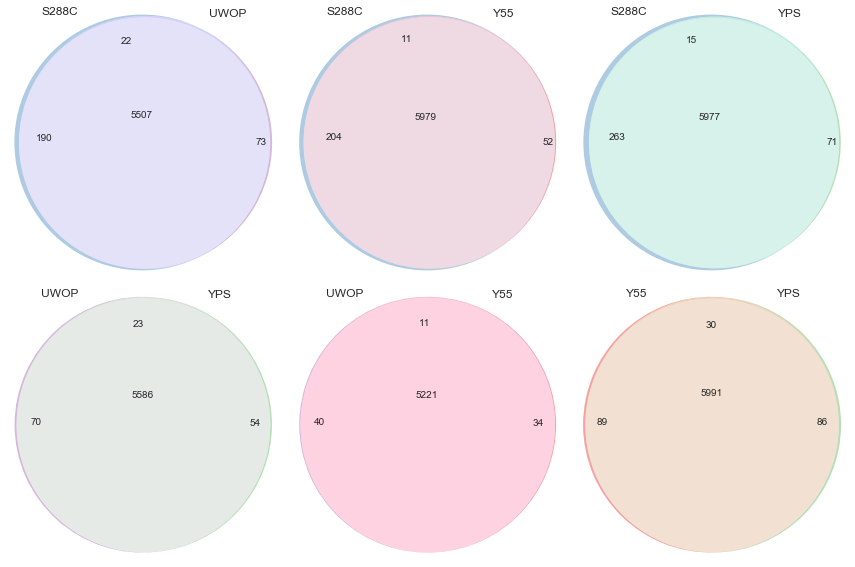

In [16]:
plt.figure(figsize=(12, 8))

for i, t in enumerate(res):
    plt.subplot(2, 3, i+1)
    
    (vs1, vs, vs2, vs3), (s1, s2) = t
    
    _ = venn3([vs1, vs2, vs3,
               0, 0, 0, vs],
              [s1, s2, ''],
              normalize_to=10,
              set_colors=[cstrains[s1],
                          cstrains[s2],
                          'w'])
plt.tight_layout()

In [17]:
y = d[(d['phenotype1'] |
       d['phenotype2'])].reset_index().set_index(['gene',
                                                  'condition']).sort_index()
phenotypes = {(x[0], x[1])
              for x in y.index}

In [18]:
sh = y[(y['phenotype1']) & (y['phenotype2']) & (y['qvalue'] > 0.01)].shape[0] / y.shape[0]
sw = y[(y['phenotype1']) & (y['phenotype2']) & (y['qvalue'] <= 0.01) &
       (np.sign(y['scores1']) != np.sign(y['scores2']))].shape[0] / y.shape[0]
se = y[((y['phenotype1']) | (y['phenotype2'])) &
       (y['qvalue'] <= 0.01)].shape[0] / y.shape[0]
e = y[(((y['phenotype1']) & (y['phenotype2'] == False)) |
      ((y['phenotype2']) & (y['phenotype1'] == False))) &
      (y['qvalue'] >= 0.01)].shape[0] / y.shape[0]
res = [('shared', sh),
       ('switched', sw),
       ('superexclusive', se),
       ('exclusive', e)]
r = pd.DataFrame(res,
                 columns=['variable',
                          'proportion'])

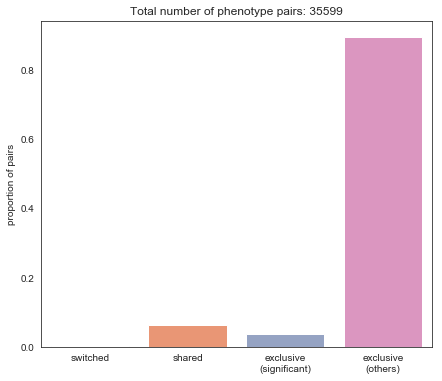

In [19]:
plt.figure(figsize=(7, 6))

sns.barplot(x='variable',
            y='proportion',
            data=r,
            palette='Set2',
            order=['switched',
                   'shared',
                   'superexclusive',
                   'exclusive'])

plt.ylabel('proportion of pairs')
plt.xlabel('')

plt.xticks(range(4),
           ['switched',
            'shared',
            'exclusive\n(significant)',
            'exclusive\n(others)']);

plt.title('Total number of phenotype pairs: %d' % y.shape[0]);

In [20]:
res = []
for phen in phenotypes:
    x = y.loc[(phen[0],
               phen[1]),]
    p = x.shape[0]
    sh = x[(x['phenotype1']) & (x['phenotype2'])]
    se = x[((x['phenotype1']) | (x['phenotype2'])) &
           (x['qvalue'] <= 0.01)]
    e = x[(((x['phenotype1']) & (x['phenotype2'] == False)) |
          ((x['phenotype2']) & (x['phenotype1'] == False))) &
          (x['qvalue'] >= 0.01)]    
    shs = {y for x in sh[['strain1', 'strain2']].values for y in x}
    ses = set(se[se['phenotype1']]['strain1']).union(se[se['phenotype2']]['strain2'])
    es = set(e[e['phenotype1']]['strain1']).union(e[e['phenotype2']]['strain2'])
    if sh.shape[0] > 0:
        res.append((phen[0], phen[1], 'shared', len(shs)))
    else:
        res.append((phen[0], phen[1], 'exclusive', len(ses.union(es))))
r = pd.DataFrame(res,
                 columns=['gene',
                          'condition',
                          'variable',
                          'strains'])

In [21]:
p = (r.groupby(['strains'])['gene'].count() / len(phenotypes)).reset_index()

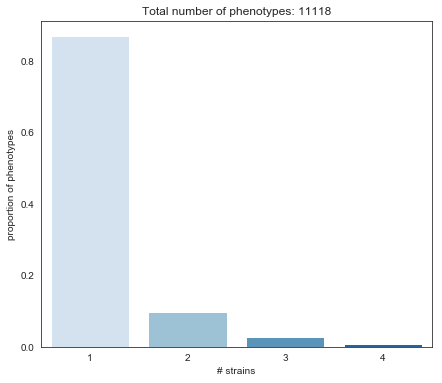

In [22]:
plt.figure(figsize=(7, 6))

sns.barplot(x='strains',
            y='gene',
            data=p,
            palette='Blues')

plt.ylabel('proportion of phenotypes')
plt.xlabel('# strains')

plt.title('Total number of phenotypes: %d' % (len(phenotypes)));

In [23]:
res = []
for s1, s2 in sorted({tuple(x[:2])
                      for x in d.index},
                     key=lambda x: x[1]):
    y = d.loc[(s1, s2), ]
    
    p1 = y[y['phenotype1']].shape[0]
    p2 = y[y['phenotype2']].shape[0]

    x = y[(y['phenotype1']) | (y['phenotype2'])]
    
    sw = x[(x['phenotype1']) & (x['phenotype2']) &
           (np.sign(x['scores1']) != np.sign(x['scores2'])) & (x['qval'] < 0.01)].shape[0]
    
    se1 = x[(x['phenotype1']) & (x['qvalue'] < 0.01)].shape[0]
    se2 = x[(x['phenotype2']) & (x['qvalue'] < 0.01)].shape[0]
    
    sh1 = x[(x['phenotype1']) & (x['phenotype2']) & (x['qvalue'] >= 0.01)].shape[0]
    sh2 = x[(x['phenotype2']) & (x['phenotype1']) & (x['qvalue'] >= 0.01)].shape[0]
    
    e1 = x[(x['phenotype1']) & (x['phenotype2'] == False) & (x['qvalue'] >= 0.01)].shape[0]
    e2 = x[(x['phenotype2']) & (x['phenotype1'] == False) & (x['qvalue'] >= 0.01)].shape[0]
    
    res.append((s1, s2, y.shape[0], p1, sh1+se1, sh1, se1, e1, sw))
    res.append((s2, s1, y.shape[0], p2, sh1+se1, sh2, se2, e2, sw))

r = pd.DataFrame(res,
                 columns=['strain', 'other',
                          'scores',
                          'phenotypes1', 'phenotypes',
                          'shared',
                          'superexclusive',
                          'exclusive',
                          'switches'])
r['pshared'] = r['shared'] / r['phenotypes']
r['psuperexclusive'] = r['superexclusive'] / r['phenotypes']
r['pexclusive'] = r['exclusive'] / r['phenotypes']
r['pswitches'] = r['switches'] / r['phenotypes']

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


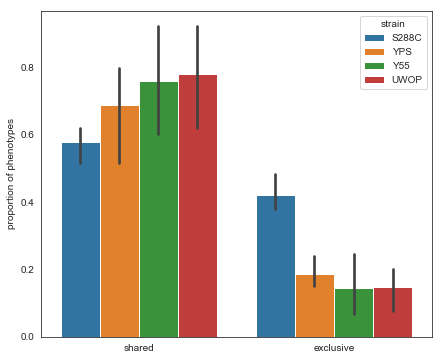

In [24]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['psuperexclusive',
                          'pshared'])]

plt.figure(figsize=(7, 6))

sns.barplot(x='variable',
            y='value',
            hue='strain',
            data=p,
            hue_order=r.groupby('strain').mean().sort_values('pshared').index,
            order=['pshared',
                   'psuperexclusive'])

plt.ylabel('proportion of phenotypes')
plt.xlabel('')

plt.xticks(range(2),
           ['shared', 'exclusive']);

In [25]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [26]:
res = []
for s1, s2 in sorted({tuple(x[:2])
                      for x in d.index},
                     key=lambda x: x[1]):
    y = d.loc[(s1, s2), ]
    
    p1 = y[y['phenotype1']].shape[0]
    p2 = y[y['phenotype2']].shape[0]

    x = y[(y['phenotype1']) | (y['phenotype2'])]
    
    sw = x[(x['phenotype1']) & (x['phenotype2']) & (np.sign(x['scores1']) != np.sign(x['scores2'])) & (x['qval'] < 0.01)].shape[0]
    
    e1 = x[(x['phenotype1']) & (x['qvalue'] < 0.01)].shape[0]
    e2 = x[(x['phenotype2']) & (x['qvalue'] < 0.01)].shape[0]
    
    sh1 = x[(x['phenotype1']) & (x['phenotype2'])
            & (x['qvalue'] >= 0.01)].shape[0]
    sh2 = x[(x['phenotype2']) & (x['phenotype1'])
            & (x['qvalue'] >= 0.01)].shape[0]
    
    res.append((s1, s2, y.shape[0], sh1+e1, sh1, e1, sw))
    res.append((s2, s1, y.shape[0], sh1+e1, sh2, e2, sw))

r = pd.DataFrame(res,
                 columns=['strain', 'other',
                          'scores',
                          'phenotypes',
                          'shared',
                          'exclusive',
                          'switches'])
r['pshared'] = r['shared'] / r['phenotypes']
r['pexclusive'] = r['exclusive'] / r['phenotypes']
r['pswitches'] = r['switches'] / r['phenotypes']

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


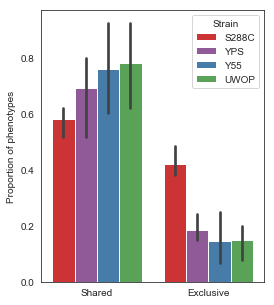

In [27]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['pshared',
                          'pexclusive'])]

plt.figure(figsize=(4, 5))

sns.barplot(x='variable',
            y='value',
            hue='strain',
            data=p,
            hue_order=r.groupby('strain').mean().sort_values('pshared').index,
            palette=[cstrains[x] for x in 
                     r.groupby('strain').mean().sort_values('pshared').index])

plt.ylabel('Proportion of phenotypes')
plt.xlabel('')

plt.xticks(range(2),
           ['Shared', 'Exclusive'])

plt.legend(title='Strain',
           ncol=1)

plt.savefig('deviations-sets.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations-sets.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


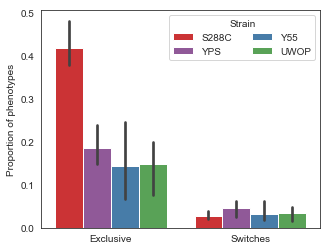

In [28]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['pexclusive',
                          'pswitches'])]

plt.figure(figsize=(5, 4))

sns.barplot(x='variable',
            y='value',
            hue='strain',
            data=p,
            hue_order=r.groupby('strain').mean().sort_values('pshared').index,
            palette=[cstrains[x] for x in
                     r.groupby('strain').mean().sort_values('pshared').index])

plt.ylabel('Proportion of phenotypes')
plt.xlabel('')

plt.xticks(range(2),
           ['Exclusive', 'Switches'])

plt.legend(title='Strain',
           ncol=2)

plt.savefig('deviations-sets-zoom.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations-sets-zoom.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

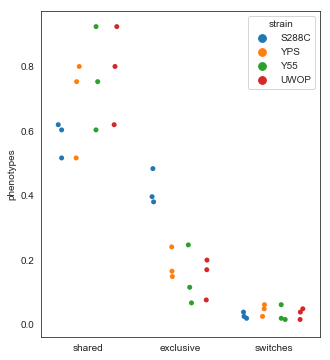

In [29]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['pshared',
                          'pexclusive',
                          'pswitches'])]

plt.figure(figsize=(5, 6))

sns.stripplot(x='variable',
              y='value',
              hue='strain',
              data=p,
              hue_order=r.groupby('strain').mean().sort_values('pshared').index,
              dodge=True)

plt.ylabel('phenotypes')
plt.xlabel('')

plt.xticks(range(3),
           ['shared', 'exclusive', 'switches']);

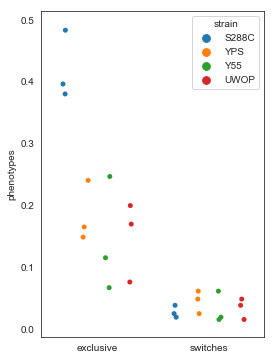

In [30]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['pexclusive',
                          'pswitches'])]

plt.figure(figsize=(4, 6))

sns.stripplot(x='variable',
              y='value',
              hue='strain',
              data=p,
              hue_order=r.groupby('strain').mean().sort_values('pshared').index,
              dodge=True)

plt.ylabel('phenotypes')
plt.xlabel('')

plt.xticks(range(2),
           ['exclusive', 'switches']);

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


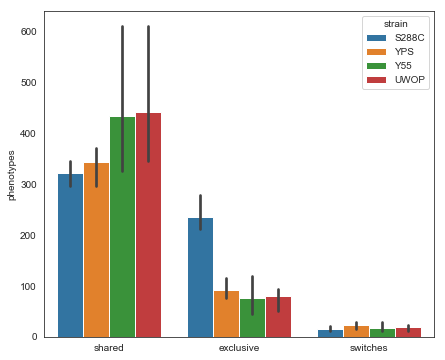

In [31]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['shared',
                          'exclusive',
                          'switches'])]

plt.figure(figsize=(7, 6))

sns.barplot(x='variable',
            y='value',
            hue='strain',
            data=p,
            hue_order=r.groupby('strain').mean().sort_values('pshared').index)

plt.ylabel('phenotypes')
plt.xlabel('')

plt.xticks(range(3),
           ['shared', 'exclusive', 'switches']);

In [43]:
res = []
for s1, s2, c in sorted({tuple(list(x[:2]) + [x[-1]])
                         for x in d.index},
                       key=lambda x: x[1]):
    y = d.loc[(s1, s2, slice(None), c), ]
    
    p1 = y[y['phenotype1']].shape[0]
    p2 = y[y['phenotype2']].shape[0]

    x = y[(y['phenotype1']) | (y['phenotype2'])]
    
    sw = x[(x['phenotype1']) & (x['phenotype2']) & (np.sign(x['scores1']) != np.sign(x['scores2'])) & (x['qval'] < 0.01)].shape[0]
    
    e1 = x[(x['phenotype1']) & (x['qvalue'] < 0.01)].shape[0]
    e2 = x[(x['phenotype2']) & (x['qvalue'] < 0.01)].shape[0]
    ep1 = x[(x['phenotype1']) & (x['qvalue'] < 0.01) & (x['scores1'] > 0)].shape[0]
    ep2 = x[(x['phenotype2']) & (x['qvalue'] < 0.01) & (x['scores2'] > 0)].shape[0]
    en1 = x[(x['phenotype1']) & (x['qvalue'] < 0.01) & (x['scores1'] < 0)].shape[0]
    en2 = x[(x['phenotype2']) & (x['qvalue'] < 0.01) & (x['scores2'] < 0)].shape[0]
    
    sh1 = x[(x['phenotype1']) & (x['qvalue'] >= 0.01)].shape[0]
    sh2 = x[(x['phenotype2']) & (x['qvalue'] >= 0.01)].shape[0]
    
    res.append((s1, s2, c, y.shape[0], p1, sh1, e1, ep1, en1, sw))
    res.append((s2, s1, c, y.shape[0], p2, sh2, e2, ep2, en2, sw))

r = pd.DataFrame(res,
                 columns=['strain', 'other',
                          'condition',
                          'scores',
                          'phenotypes',
                          'shared',
                          'exclusive',
                          'posexclusive',
                          'negexclusive',
                          'switches'])
r['pshared'] = r['shared'] / r['phenotypes']
r['pexclusive'] = r['exclusive'] / r['phenotypes']
r['pswitches'] = r['switches'] / r['phenotypes']

In [44]:
p = r.set_index(['condition', 'strain']).stack()

p = p.to_frame().reset_index()
p.columns = ['condition',
             'strain',
             'variable',
             'value']
p = p[p['variable'].isin(['shared',
                          'exclusive',
                          'posexclusive',
                          'negexclusive',
                          'switches'])]
p['value'] = p['value'].astype(float)

In [45]:
c = p.groupby(['strain', 'condition', 'variable'])['value'].mean().reset_index()

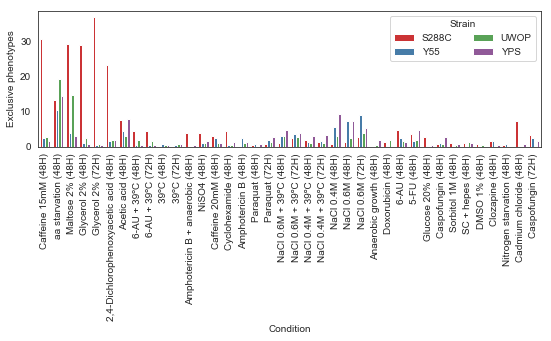

In [35]:
plt.figure(figsize=(9, 2.5))

var = 'exclusive'
sns.barplot(x='condition',
            y='value',
            hue='strain',
            data=c[c['variable'] == var],
            hue_order=strains,
            palette=[cstrains[x] for x in strains],
            order=co)

plt.legend(title='Strain',
           ncol=2,
           loc='upper right')

plt.xticks(rotation=90)

plt.xlabel('Condition')
plt.ylabel('Exclusive phenotypes');

# plt.savefig('deviations_conditions.png',
#             dpi=300, bbox_inches='tight',
#             transparent=True)
# plt.savefig('deviations_conditions.svg',
#             dpi=300, bbox_inches='tight',
#             transparent=True);

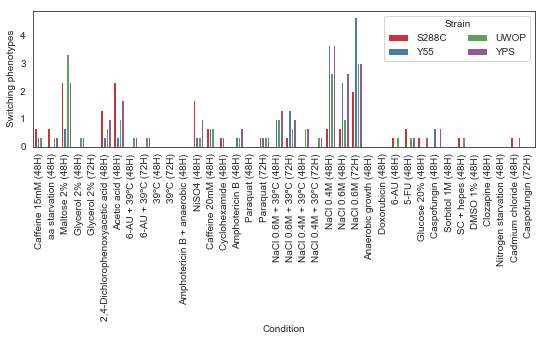

In [36]:
plt.figure(figsize=(9, 2.5))

var = 'switches'
sns.barplot(x='condition',
            y='value',
            hue='strain',
            data=c[c['variable'] == var],
            hue_order=strains,
            palette=[cstrains[x] for x in strains],
            order=co)

plt.legend(title='Strain',
           ncol=2,
           loc='upper right')

plt.xticks(rotation=90)

plt.xlabel('Condition')
plt.ylabel('Switching phenotypes');

# plt.savefig('deviations_conditions.png',
#             dpi=300, bbox_inches='tight',
#             transparent=True)
# plt.savefig('deviations_conditions.svg',
#             dpi=300, bbox_inches='tight',
#             transparent=True);

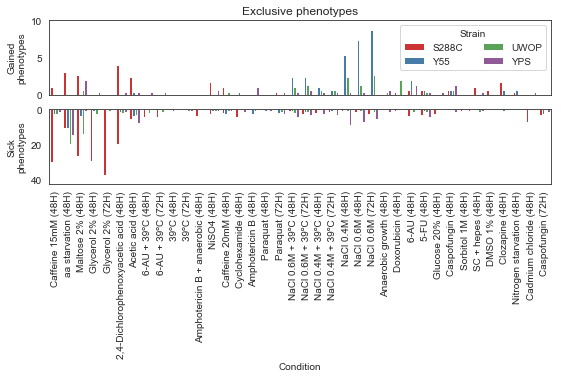

In [37]:
plt.figure(figsize=(9, 3))

plt.subplot(211)

var = 'posexclusive'
sns.barplot(x='condition',
            y='value',
            hue='strain',
            data=c[c['variable'] == var],
            hue_order=strains,
            palette=[cstrains[x] for x in strains],
            order=co)

plt.legend(title='Strain',
           ncol=2,
           loc='upper right')

plt.ylim(0, 10)
plt.xlabel('')
plt.xticks([])
plt.yticks([0, 5, 10],
           [str(x) for x in [0, 5, 10]])
plt.ylabel('Gained\nphenotypes')
plt.title('Exclusive phenotypes')

plt.subplot(212)

var = 'negexclusive'
sns.barplot(x='condition',
            y='value',
            hue='strain',
            data=c[c['variable'] == var],
            hue_order=strains,
            palette=[cstrains[x] for x in strains],
            order=co)

plt.ylim(0, 42)
plt.xticks(rotation=90)

plt.xlabel('Condition')
plt.ylabel('Sick\nphenotypes')

plt.gca().invert_yaxis()
plt.gca().legend().remove()

plt.subplots_adjust(hspace=0.2);

plt.savefig('deviations_conditions.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_conditions.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [46]:
rco = ['Caffeine 15mM (48H)',
       'aa starvation (48H)',
       'Glycerol 2% (48H)',
       'Glycerol 2% (72H)',
       'Maltose 2% (48H)',
       'NaCl 0.4M (48H)',
       'NaCl 0.6M (48H)',
       'NaCl 0.6M (72H)']

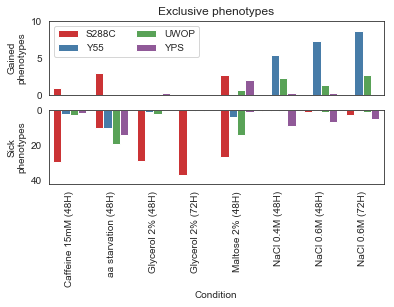

In [50]:
plt.figure(figsize=(6, 3))

plt.subplot(211)

var = 'posexclusive'
sns.barplot(x='condition',
            y='value',
            hue='strain',
            data=c[(c['variable'] == var) &
                   (c['condition'].isin(rco))],
            hue_order=strains,
            palette=[cstrains[x] for x in strains],
            order=rco)

plt.legend(ncol=2,
           loc='upper left',
           bbox_to_anchor=(0, 1))
# plt.gca().legend().remove()

# plt.ylim(0, 15)
plt.xlabel('')
plt.xticks([])
plt.yticks([0, 5, 10],
           [str(x) for x in [0, 5, 10]])
plt.ylabel('Gained\nphenotypes')
plt.title('Exclusive phenotypes')

plt.subplot(212)

var = 'negexclusive'
sns.barplot(x='condition',
            y='value',
            hue='strain',
            data=c[(c['variable'] == var) &
                   (c['condition'].isin(rco))],
            hue_order=strains,
            palette=[cstrains[x] for x in strains],
            order=rco)

plt.ylim(0, 42)
plt.xticks(rotation=90)

plt.xlabel('Condition')
plt.ylabel('Sick\nphenotypes')

plt.gca().invert_yaxis()
plt.gca().legend().remove()

plt.subplots_adjust(hspace=0.2);

plt.savefig('deviations_conditions_zoom.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations_conditions_zoom.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


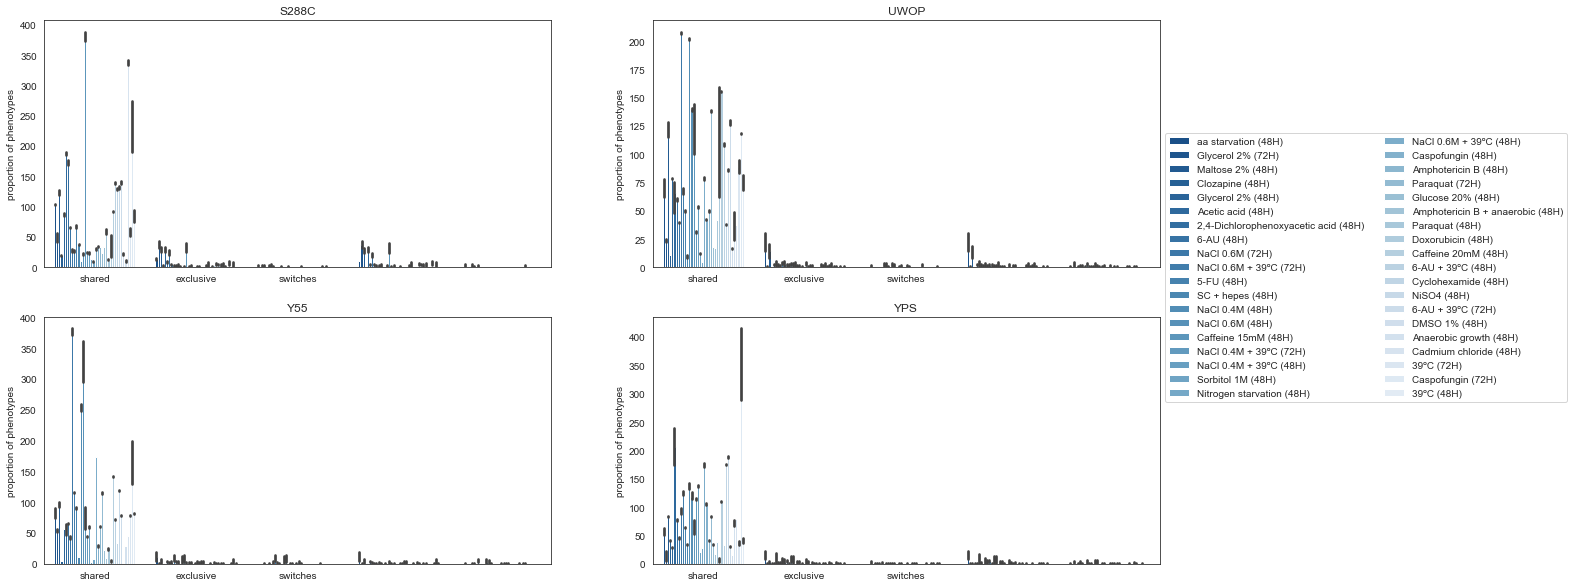

In [40]:
plt.figure(figsize=(20, 10))

for i, strain in enumerate(sorted(r['strain'].unique())):
    plt.subplot(2, 2, i+1)
    
    sns.barplot(x='variable',
                y='value',
                hue='condition',
                data=p[p['strain'] == strain],
                hue_order=r.groupby('condition').mean().sort_values('pshared').index,
                palette=sns.color_palette('Blues_r', len(r['condition'].unique())+10)[5:])

    plt.ylabel('proportion of phenotypes')
    plt.xlabel('')

    plt.xticks(range(3),
               ['shared', 'exclusive', 'switches'])

    if i == 1:
        plt.legend(bbox_to_anchor=(1, 0),
                   loc='center left',
                   frameon=True,
                   ncol=2)
    else:
        ax = plt.gca()
        ax.legend_ = None
    
    plt.title(strain)

In [41]:
p = r.set_index(['condition', 'strain']).stack()

p = p.to_frame().reset_index()
p.columns = ['condition',
             'strain',
             'variable',
             'value']
p = p[p['variable'].isin(['pexclusive',
                          'pswitches'])]

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


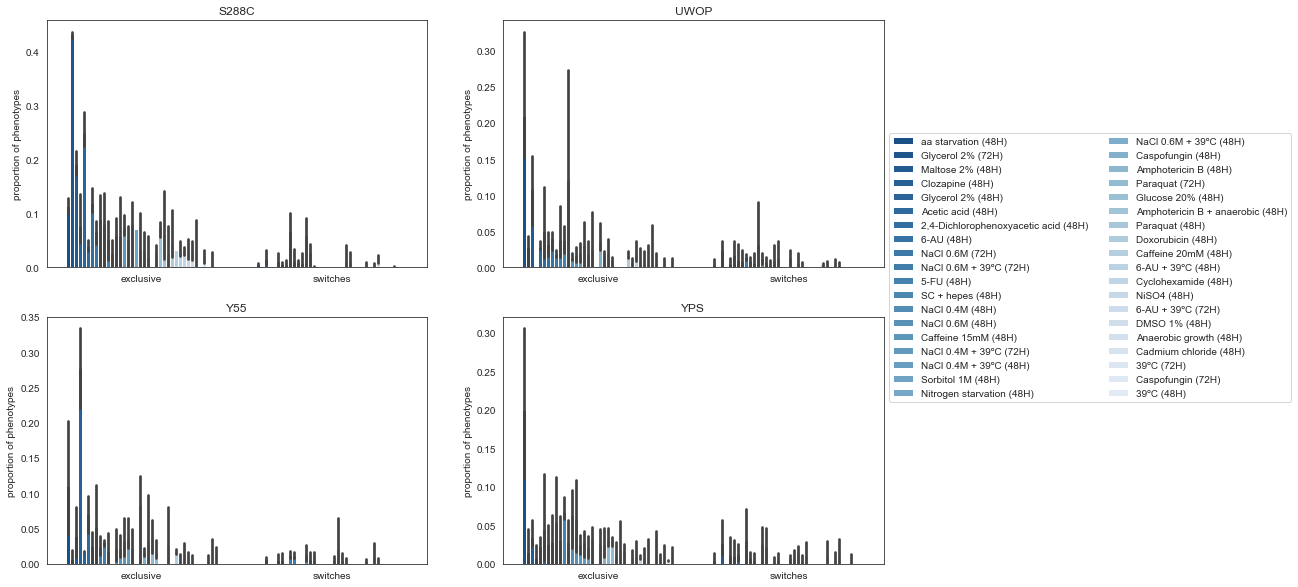

In [42]:
plt.figure(figsize=(15, 10))

for i, strain in enumerate(sorted(r['strain'].unique())):
    plt.subplot(2, 2, i+1)
    
    sns.barplot(x='variable',
                y='value',
                hue='condition',
                data=p[p['strain'] == strain],
                hue_order=r.groupby('condition').mean().sort_values('pexclusive',
                                                                    ascending=False).index,
                palette=sns.color_palette('Blues_r', len(r['condition'].unique())+10)[5:])

    plt.ylabel('proportion of phenotypes')
    plt.xlabel('')

    plt.xticks(range(2),
               ['exclusive', 'switches'])

    if i == 1:
        plt.legend(bbox_to_anchor=(1, 0),
                   loc='center left',
                   frameon=True,
                   ncol=2)
    else:
        ax = plt.gca()
        ax.legend_ = None
    
    plt.title(strain)